In [1]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd

import folium
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def requestData(url):

    payload={}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)
    return response 

In [3]:
url = "http://127.0.0.1:9090/get-asthma-avg"
response = requestData(url)
asthma_df = pd.DataFrame(response.json())

In [4]:
asthma_df

,suburb,average_asthma_rate,average_respiratory_rate
0,Orbost,11.675567,30.185637
1,Wonthaggi - Inverloch,13.611581,30.029335
2,Ballarat,15.146919,35.669154
3,Benalla,14.110733,31.295576
4,Buloke,13.776186,32.201810
5,Camberwell,9.456149,29.475693
6,Camperdown,13.211534,35.170746
7,Coburg - West,9.430242,28.903187
8,Colac,13.596720,34.798039
9,Corio - Lovely Banks,13.071453,29.966815


In [5]:
url = "http://127.0.0.1:9090/epa"
response = requestData(url)
epa_data = []
for item in response.json()['hits']:
    epa_data.append(item['_source'])

In [6]:
# epa_data

In [7]:
import geopandas as gpd
import json
from shapely.geometry import Point

# Replace with the proper path
file_path = "../data/SA2-Map/SA2_2021_AUST_GDA2020.shp"
sa2_gdf = gpd.read_file(file_path)
sa2_gdf = sa2_gdf.to_crs(epsg=4326)


# Create GeoDataFrame from EPA data
records = []
for entry in epa_data:
    lat = entry['coordinates']['lat']
    lon = entry['coordinates']['lon']
    try:
        lat = float(lat)
        lon = float(lon)
    except:
        lat = np.nan
        lon = np.nan
    point = Point(lon, lat)
    records.append({'averageValue': entry['averageValue'], 'geometry': point, 'lat': lat, 'lon':lon})

gdf = gpd.GeoDataFrame(records, geometry='geometry', crs="EPSG:4326")

# Project to a suitable CRS for spatial operations
gdf_projected = gdf.to_crs(epsg=3857)
sa2_gdf_projected = sa2_gdf.to_crs(epsg=3857)

# Perform spatial join to add suburb names
gdf_with_sa2 = gpd.sjoin_nearest(gdf_projected, sa2_gdf_projected, how='left', distance_col='distance')

# Extract and add 'suburb' names
gdf_with_sa2['suburb'] = gdf_with_sa2['SA2_NAME21']

# Create the updated data structure
updated_data = []
for index, row in gdf_with_sa2.iterrows():
    entry = {
        'averageValue': row['averageValue'],
        'suburb': row['suburb'],
        'lat': row['lat'],
        'lon': row['lon']
    }
    updated_data.append(entry)

# Save the updated JSON data
with open('updated_epa_data.json', 'w') as json_output_file:
    json.dump(updated_data, json_output_file, indent=2)

print("Updated data saved successfully")

Updated data saved successfully


In [26]:
epa_df = pd.DataFrame(updated_data)
# epa_df
combined_df = pd.merge(asthma_df, epa_df, how='inner', on='suburb')

In [18]:
len(asthma_df), len(epa_df)

(48, 529)

In [9]:
combined_df

,suburb,average_asthma_rate,average_respiratory_rate,averageValue,lat,lon
0,Geelong,12.536743,30.277138,7.04,-38.17356,144.3703
1,Geelong,12.536743,30.277138,7.04,-38.17356,144.3703
2,Geelong,12.536743,30.277138,7.04,-38.17356,144.3703
3,Geelong,12.536743,30.277138,7.04,-38.17356,144.3703
4,Geelong,12.536743,30.277138,1.03,-38.17356,144.3703
...,...,...,...,...,...,...
79,Wangaratta,13.862166,31.607744,56.78,-36.36926,146.3133
80,Wangaratta,13.862166,31.607744,56.78,-36.36926,146.3133
81,Wangaratta,13.862166,31.607744,56.78,-36.36926,146.3133
82,Wangaratta,13.862166,31.607744,56.78,-36.36926,146.3133


In [49]:
avg_values = combined_df.groupby('suburb').agg({'averageValue': 'mean', 'lat': 'first', 'lon': 'first', 'average_asthma_rate': 'first', 'average_respiratory_rate':'first'}).reset_index()
avg_values

,suburb,averageValue,lat,lon,average_asthma_rate,average_respiratory_rate
0,Geelong,6.387143,-38.17356,144.3703,12.536743,30.277138
1,Mildura - North,3.620000,-34.19561,142.1616,13.943366,30.603093
2,Swan Hill,2.558095,-35.34331,143.5341,12.865515,29.493471
3,Wangaratta,47.958571,-36.36926,146.3133,13.862166,31.607744


## plot

<AxesSubplot:xlabel='average_asthma_rate', ylabel='averageValue'>

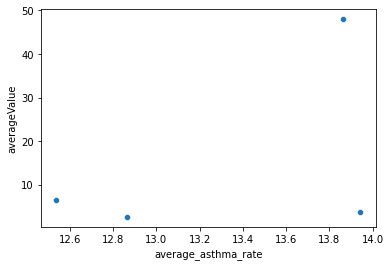

In [50]:
sns.scatterplot(data=avg_values, x="average_asthma_rate", y="averageValue")

<AxesSubplot:xlabel='average_respiratory_rate', ylabel='averageValue'>

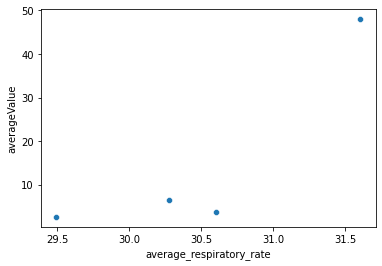

In [51]:
sns.scatterplot(data=avg_values, x="average_respiratory_rate", y="averageValue")

In [22]:
epa_df.head()

,averageValue,suburb,lat,lon
0,7.51,Box Hill,-37.828728,145.1324
1,4.45,Alphington - Fairfield,-37.778408,145.0306
2,11.92,Morwell,-38.239292,146.3873
3,8.44,Bright - Mount Beauty,-36.732280,146.9702
4,1.97,Kingsbury,-37.722477,145.0576


In [12]:
epa_df

,averageValue,suburb,lat,lon
0,7.51,Box Hill,-37.828728,145.1324
1,4.45,Alphington - Fairfield,-37.778408,145.0306
2,11.92,Morwell,-38.239292,146.3873
3,8.44,Bright - Mount Beauty,-36.732280,146.9702
4,1.97,Kingsbury,-37.722477,145.0576
...,...,...,...,...
524,5.23,Point Cook - East,-37.926315,144.7567
525,11.49,Kingsbury,-37.722477,145.0576
526,17.65,Rosedale,-38.155880,146.7842
527,4.70,Yarraville,-37.811910,144.8741


In [13]:
geometry = gpd.points_from_xy(epa_df.lon, epa_df.lat)
geo_stations = gpd.GeoDataFrame(
    epa_df[["suburb", "averageValue"]], geometry=geometry
)
geo_stations

,suburb,averageValue,geometry
0,Box Hill,7.51,POINT (145.13240 -37.82873)
1,Alphington - Fairfield,4.45,POINT (145.03060 -37.77841)
2,Morwell,11.92,POINT (146.38730 -38.23929)
3,Bright - Mount Beauty,8.44,POINT (146.97020 -36.73228)
4,Kingsbury,1.97,POINT (145.05760 -37.72248)
...,...,...,...
524,Point Cook - East,5.23,POINT (144.75670 -37.92632)
525,Kingsbury,11.49,POINT (145.05760 -37.72248)
526,Rosedale,17.65,POINT (146.78420 -38.15588)
527,Yarraville,4.70,POINT (144.87410 -37.81191)


In [14]:
map = folium.Map(location=[-36.525075, 144.883471], tiles="OpenStreetMap", zoom_start=7)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_stations.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # # assign a color marker for the type of volcano, Strato being the most common
    # if geo_stations.AWS[i] == "N":
    #     type_color = "green"
    # elif geo_stations.AWS[i] == "Y":
    #     type_color = "blue"
    # # elif geo_df.AWS[i] == "Shield volcano":
    # #     type_color = "orange"
    # # elif geo_df.Type[i] == "Lava dome":
    # #     type_color = "pink"
    # else:
    #     type_color = "red"
    type_color = "red"
    # Place the markers with the popup labels and data
    map.add_child(
        folium.Marker(
            location=coordinates,
            popup=
            # "Site: " + 
            str(geo_stations.suburb[i])
            + "<br>"
            + "averageValue "
            + str(geo_stations.averageValue[i]),
            # + str(geo_df_list[i]),
            icon=folium.Icon(color="%s" % type_color),
        )
    )
    i = i + 1


In [15]:
map

In [30]:
epa_df

,averageValue,suburb,lat,lon
0,7.51,Box Hill,-37.828728,145.1324
1,4.45,Alphington - Fairfield,-37.778408,145.0306
2,11.92,Morwell,-38.239292,146.3873
3,8.44,Bright - Mount Beauty,-36.732280,146.9702
4,1.97,Kingsbury,-37.722477,145.0576
...,...,...,...,...
524,5.23,Point Cook - East,-37.926315,144.7567
525,11.49,Kingsbury,-37.722477,145.0576
526,17.65,Rosedale,-38.155880,146.7842
527,4.70,Yarraville,-37.811910,144.8741


In [45]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# 示例数据框
# data = {
#     'suburb': ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C'],
#     'averageValue': [10, 15, 14, 22, 23, 21, 30, 28, 29],
#     'latitude': [-33.8688, -33.8688, -33.8688, -37.8136, -37.8136, -37.8136, -27.4698, -27.4698, -27.4698],
#     'longitude': [151.2093, 151.2093, 151.2093, 144.9631, 144.9631, 144.9631, 153.0251, 153.0251, 153.0251]
# }
# epa_df = pd.DataFrame(data)

# 创建地图图表
fig_map = px.scatter_geo(combined_df, lat='lat', lon='lon', text='suburb',
                         projection='natural earth')

# 创建箱线图
fig_box = px.box(combined_df, x='suburb', y='averageValue')

# 创建包含子图的布局
fig = make_subplots(
    rows=2, cols=1,
    specs=[[{'type': 'scattergeo'}],
           [{'type': 'box'}]],
    subplot_titles=('Map of Australia', 'Boxplot of Average Values')
)

# 添加地图到子图布局中
for trace in fig_map.data:
    fig.add_trace(trace, row=1, col=1)

# 添加箱线图到子图布局中
for trace in fig_box.data:
    fig.add_trace(trace, row=2, col=1)

# 更新地图布局
fig.update_geos(scope='world', row=1, col=1)

# 更新整体布局
fig.update_layout(
    title_text='Map with Boxplots in Australia',
    height=800
)

fig.show()
